In [1]:
import pandas as pd
import numpy as np
from scipy.fft import rfft,rfftfreq
from scipy import signal
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Assuming 'df' is the original dataframe with 3200Hz frequency
original_freq = 3200
target_freq = 200

In [3]:
def filter_signal(sig, pass_freq, stop_freq, attenuation, sample_f):
    N, Wn = signal.buttord(wp=pass_freq, ws=stop_freq, gpass=1, gstop=attenuation, analog=False, fs=sample_f)
    sos = signal.butter(N,Wn,fs=sample_f, btype="low", analog=False, output="sos")
    return signal.sosfilt(sos, sig)

def create_filter(pass_freq, stop_freq, attenuation, sample_f):
    N, Wn = signal.buttord(wp=pass_freq, ws=stop_freq, gpass=1, gstop=attenuation, analog=False, fs=sample_f)
    sos = signal.butter(N,Wn,fs=sample_f, btype="low", analog=False, output="sos")
    return sos

In [3]:
# Create a function to downsample the dataframe using the median
def downsample_with_median(df, original_freq, target_freq):
    # Calculate the downsampling factor
    factor = original_freq // target_freq
    
    # Use the rolling window to calculate the median for each window of 'factor' rows
    downsampled_df = df.rolling(window=factor).median().iloc[factor-1::factor].reset_index(drop=True)
    
    return downsampled_df

In [5]:
def downsample_with_mean(df, original_freq, target_freq):
    # Calculate the downsampling factor
    factor = original_freq // target_freq
    
    downsampled_df = df.rolling(window=factor).mean().iloc[factor-1::factor].reset_index(drop=True)
    
    return downsampled_df

In [6]:
def downsample(df, original_freq, target_freq):
    # Calculate the downsampling factor
    factor = original_freq // target_freq
    
    downsampled_df = df.iloc[factor-1::factor].reset_index(drop=True)
    
    return downsampled_df

##### Downsampling

In [15]:
f"TCC_data/processed_dataset/labeled_dataset_downsample_{target_freq}_filter"

'TCC_data/processed_dataset/labeled_dataset_downsample_200_filter'

In [7]:
destination = Path(f"TCC_data/processed_dataset/labeled_dataset_downsample_{target_freq}_filter")
destination.mkdir(parents=True)

In [8]:
pass_freq = 80      # Passband frequency (Hz)
stop_freq = 100      # Stopband frequency (Hz)
attenuation = 40    # Attenuation (dB)
sample_f = 3200     # Sampling frequency (Hz)

In [9]:
sos = create_filter(pass_freq,stop_freq,attenuation,sample_f)

for file in Path("TCC_data/labeled_dataset_typed").glob("benchy_*"):
    df = pd.read_parquet(file)
    df["accel_x"] = signal.sosfilt(sos, df["accel_x"])
    df["accel_y"] = signal.sosfilt(sos, df["accel_y"])
    df["accel_z"] = signal.sosfilt(sos, df["accel_z"])
    downsampled_df = downsample(df.drop(columns=["class"]), original_freq, target_freq)
    downsampled_df["class"] = df["class"].unique()[0]
    downsampled_df["class"] = downsampled_df["class"].astype("category")
    downsampled_df["accel_x"] = downsampled_df["accel_x"].astype("int16")
    downsampled_df["accel_y"] = downsampled_df["accel_y"].astype("int16")
    downsampled_df["accel_z"] = downsampled_df["accel_z"].astype("int16")
    print(f"{file} - {len(df.index)} - {len(downsampled_df.index)}")
    downsampled_df.to_parquet(destination/file.name,compression='gzip')

TCC_data/labeled_dataset_typed/benchy_10_temp_230.parquet.gzip - 16271000 - 1016937
TCC_data/labeled_dataset_typed/benchy_11_temp_230.parquet.gzip - 15575000 - 973437
TCC_data/labeled_dataset_typed/benchy_12_temp_230.parquet.gzip - 17189410 - 1074338
TCC_data/labeled_dataset_typed/benchy_13_healthy.parquet.gzip - 16603860 - 1037741
TCC_data/labeled_dataset_typed/benchy_14_temp_220.parquet.gzip - 16912500 - 1057031
TCC_data/labeled_dataset_typed/benchy_15_loose_head.parquet.gzip - 16618500 - 1038656
TCC_data/labeled_dataset_typed/benchy_16_loose_head.parquet.gzip - 16640400 - 1040025
TCC_data/labeled_dataset_typed/benchy_17_temp_220.parquet.gzip - 16420600 - 1026287
TCC_data/labeled_dataset_typed/benchy_18_loose_head.parquet.gzip - 17144000 - 1071500
TCC_data/labeled_dataset_typed/benchy_19_loose_head.parquet.gzip - 15867000 - 991687
TCC_data/labeled_dataset_typed/benchy_1_healthy.parquet.gzip - 16239200 - 1014950
TCC_data/labeled_dataset_typed/benchy_20_loose_head.parquet.gzip - 166660

##### Imagens para representação do TCC

Downsampling tests

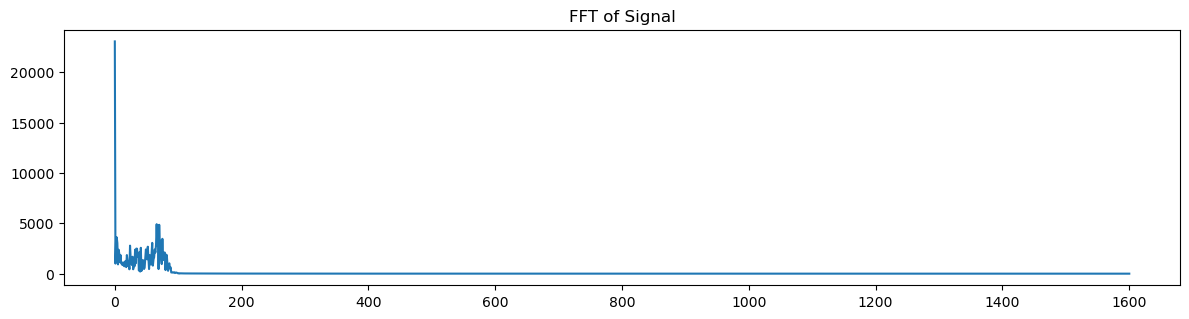

In [10]:
test = df["accel_x"][100:3300].copy()
fft_result = np.abs(rfft(test.values))
fft_freq = rfftfreq(len(test), 1/sample_f)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plt.plot(fft_freq, fft_result)
plt.title('FFT of Signal')
plt.tight_layout()
plt.show()

In [11]:
df["accel_x"] = filter_signal(df["accel_x"],pass_freq,stop_freq,attenuation,sample_f)
df["accel_y"] = filter_signal(df["accel_y"],pass_freq,stop_freq,attenuation,sample_f)
df["accel_z"] = filter_signal(df["accel_z"],pass_freq,stop_freq,attenuation,sample_f)

In [13]:
t = np.linspace(0, 3300, 3200, endpoint=False)
test2 = df["accel_y"][100:3300].copy()
fft_result = np.abs(rfft(test2.values))
fft_freq = rfftfreq(len(test2), 1/sample_f)

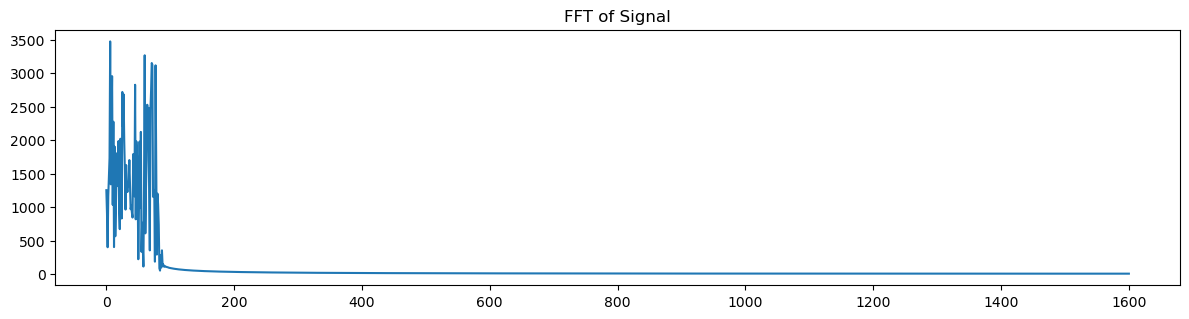

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 2)
plt.plot(fft_freq, fft_result)
plt.title('FFT of Signal')
plt.tight_layout()
plt.show()